# Waymo Open Sim Agents Challenge Tutorial 🚗

Follow along the [Sim Agents Challenge web page](https://waymo.com/open/challenges/2023/sim-agents) for more details.

This tutorial demonstrates:
- How to load the motion dataset.
- How to simulate a rollout (as specified by the challenge) from a single scenario and a simple policy.
- How to visualize the results.
- How to evaluate the simulation locally.
- How to package the simulations into the protobuf used for submission.


## Package installation 🛠️

In [8]:
!pip install waymo-open-dataset-tf-2-12-0==1.6.4

In [9]:
# Imports
import os
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm

from waymo_open_dataset.wdl_limited.sim_agents_metrics import metric_features
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metrics

from waymo_open_dataset.protos import scenario_pb2
from waymo_open_dataset.protos import sim_agents_submission_pb2

from waymo_open_dataset.utils.sim_agents import submission_specs
from waymo_open_dataset.utils.sim_agents import test_utils as sim_agents_test_utils
from waymo_open_dataset.utils.sim_agents import visualizations
from waymo_open_dataset.utils import trajectory_utils

# Set matplotlib to jshtml so animations work with colab.
from matplotlib import rc
rc('animation', html='jshtml')

# Loading the data
Visit the [Waymo Open Dataset Website](https://waymo.com/open/) to download the full dataset.

In [10]:
# Please edit.

# Replace this path with your own tfrecords./
# This tutorial is based on using data in the Scenario proto format directly,
# so choose the correct dataset version.
DATASET_FOLDER = '/waymo_open_dataset_'

TRAIN_FILES = os.path.join(DATASET_FOLDER, 'training.tfrecord*')
VALIDATION_FILES = os.path.join(DATASET_FOLDER, 'validation.tfrecord*')
TEST_FILES = os.path.join(DATASET_FOLDER, 'test.tfrecord*')

We create a dataset starting from the validation set, which is smaller than the training set but contains future states (which the test set does not). We need future information to demonstrate how to evaluate your submission locally.

In [11]:
# Define the dataset from the TFRecords.
filenames = tf.io.matching_files(VALIDATION_FILES)
dataset = tf.data.TFRecordDataset(filenames)
# Since these are raw Scenario protos, we need to parse them in eager mode.
dataset_iterator = dataset.as_numpy_iterator()

2024-05-30 14:42:19.740505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 14:42:20.143980: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-30 14:42:24.151152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

Load one example and visualize it.

In [7]:
bytes_example = next(dataset_iterator)
scenario = scenario_pb2.Scenario.FromString(bytes_example)
print(f'Checking type: {type(scenario)}')
print(f'Loaded scenario with ID: {scenario.scenario_id}')

NameError: name 'dataset_iterator' is not defined

# Simulation stage 🤖

Please read the [challenge web page](https://waymo.com/open/challenges/2023/sim-agents) first, where we explain simulation requirements and settings.

Many of the requirements specified on the challenge website are encoded into `waymo_open_dataset/utils/sim_agents/submission_specs.py`. For example, we have specifications of:
- Simulation length and frequency.
- Number of parallel simulations required.
- Agents to simulate and agents to evaluate.



In [5]:
print(f'Simulation length, in steps: {submission_specs.N_SIMULATION_STEPS}')
print(f'Duration of a step, in seconds: {submission_specs.STEP_DURATION_SECONDS}s (frequency: {1/submission_specs.STEP_DURATION_SECONDS}Hz)')
print(f'Number of parallel simulations per Scenario: {submission_specs.N_ROLLOUTS}')

Simulation length, in steps: 80
Duration of a step, in seconds: 0.1s (frequency: 10.0Hz)
Number of parallel simulations per Scenario: 32


NameError: name 'scenario' is not defined

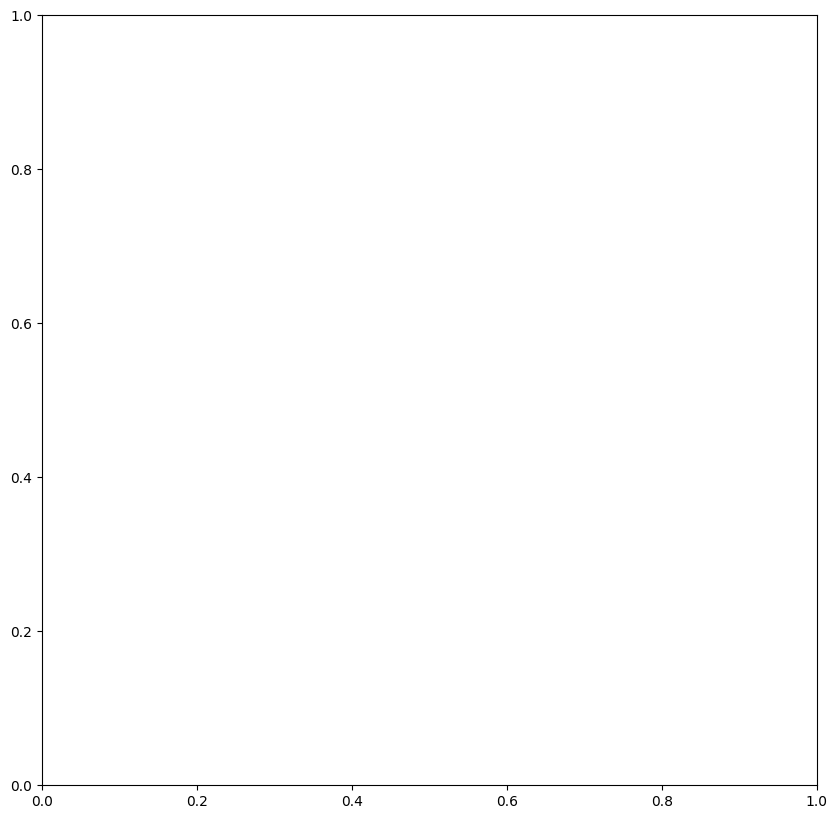

In [6]:
# Visualize scenario.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

visualizations.add_map(ax, scenario)

def plot_track_trajectory(track: scenario_pb2.Track) -> None:
  valids = np.array([state.valid for state in track.states])
  if np.any(valids):
    x = np.array([state.center_x for state in track.states])
    y = np.array([state.center_y for state in track.states])
    ax.plot(x[valids], y[valids], linewidth=5)

for track in scenario.tracks:
  plot_track_trajectory(track)

plt.show();

### What to simulate
There are multiple levels of fidelity we could ask to perform these simulations, but we are going to follow a very similar abstraction used for the Waymo Open Motion Dataset: we represent objects as boxes, and we are interested just in how they *move* around the world.

Specifically, contestants will need to simulate the fields specified in the `sim_agents_submission_pb2.SimulatedTrajectory` proto, namely:
- 3D coordinates of the boxes centers (x/y/z, same reference frame as the original Scenario).
- Heading of those objects (again, same definition as the original Scenario proto).

All the objects that are valid at the last step of the initial state (i.e. the 11th when 1-indexed, the last observable one in the test set data) needs to be resimulated. We provide a simple util function (shown below) to identify who needs to be resimulated.


In [12]:
print(f'Objects to be resimulated: {submission_specs.get_sim_agent_ids(scenario)}')
print(f'Total objects to be resimulated: {len(submission_specs.get_sim_agent_ids(scenario))}')

# Plot their tracks.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
visualizations.add_map(ax, scenario)

for track in scenario.tracks:
  if track.id in submission_specs.get_sim_agent_ids(scenario):
    plot_track_trajectory(track)

plt.show();

NameError: name 'scenario' is not defined

To demonstrate how a simulation needs to be carried out, we implement a very trivial policy for our sim agents, i.e. a linear extrapolation of their past trajectory, at constant speed. Since these agents will not be reactive, this will result in a bad score in the final evaluation (more details below).

We want to highlight 2 main properties of the simulation:
- The simulation is carried on in a **closed-loop** fashion, iterating over the steps and having the policies "observe" up to that step the action of the others.
- These policies are not sharing any information about the future intentions of each other. This is not strictly required for every agent except the AV, but it is required between the AV and everyone else (because it will be swapped with a non-controlled agent when testing in an actual AV simulator).

For more details refer to the [challenge's web page](https://waymo.com/open/challenges/2023/sim-agents).

In [ ]:
def simulate_with_extrapolation(
    scenario: scenario_pb2.Scenario,
    print_verbose_comments: bool = True) -> tf.Tensor:
  vprint = print if print_verbose_comments else lambda arg: None

  # To load the data, we create a simple tensorized version of the object tracks.
  logged_trajectories = trajectory_utils.ObjectTrajectories.from_scenario(scenario)
  # Using `ObjectTrajectories` we can select just the objects that we need to
  # simulate and remove the "future" part of the Scenario.
  vprint(f'Original shape of tensors inside trajectories: {logged_trajectories.valid.shape} (n_objects, n_steps)')
  logged_trajectories = logged_trajectories.gather_objects_by_id(
      tf.convert_to_tensor(submission_specs.get_sim_agent_ids(scenario)))
  logged_trajectories = logged_trajectories.slice_time(
      start_index=0, end_index=submission_specs.CURRENT_TIME_INDEX + 1)
  vprint(f'Modified shape of tensors inside trajectories: {logged_trajectories.valid.shape} (n_objects, n_steps)')

  # We can verify that all of these objects are valid at the last step.
  vprint(f'Are all agents valid: {tf.reduce_all(logged_trajectories.valid[:, -1]).numpy()}')

  # We extract the speed of the sim agents (in the x/y/z components) ready for
  # extrapolation (this will be our policy).
  states = tf.stack([logged_trajectories.x, logged_trajectories.y,
                    logged_trajectories.z, logged_trajectories.heading],
                    axis=-1)
  n_objects, n_steps, _ = states.shape
  last_velocities = states[:, -1, :3] - states[:, -2, :3]
  # We also make the heading constant, so concatenate 0. as angular speed.
  last_velocities = tf.concat(
      [last_velocities, tf.zeros((n_objects, 1))], axis=-1)
  # It can happen that the second to last state of these sim agents might be
  # invalid, so we will set a zero speed for them.
  vprint(f'Is any 2nd to last state invalid: {tf.reduce_any(tf.logical_not(logged_trajectories.valid[:, -2]))}')
  vprint(f'This will result in either min or max speed to be really large: {tf.reduce_max(tf.abs(last_velocities))}')
  valid_diff = tf.logical_and(logged_trajectories.valid[:, -1],
                              logged_trajectories.valid[:, -2])
  # `last_velocities` shape: (n_objects, 4).
  last_velocities = tf.where(valid_diff[:, tf.newaxis],
                            last_velocities,
                            tf.zeros_like(last_velocities))
  vprint(f'Now this should be back to a normal value: {tf.reduce_max(tf.abs(last_velocities))}')

  # Now we carry over a simulation. As we discussed, we actually want 32 parallel
  # simulations, so we make this batched from the very beginning. We add some
  # random noise on top of our actions to make sure the behaviours are different.
  # To properly scale the noise, we get the max velocities (average over all
  # objects, corresponding to axis 0) in each of the dimensions (x/y/z/heading).
  NOISE_SCALE = 0.01
  # `max_action` shape: (4,).
  max_action = tf.reduce_max(last_velocities, axis=0)
  # We create `simulated_states` with shape (n_rollouts, n_objects, n_steps, 4).
  simulated_states = tf.tile(states[tf.newaxis, :, -1:, :], [submission_specs.N_ROLLOUTS, 1, 1, 1])
  vprint(f'Shape: {simulated_states.shape}')

  for step in range(submission_specs.N_SIMULATION_STEPS):
    current_state = simulated_states[:, :, -1, :]
    # Random actions, take a normal and normalize by min/max actions
    action_noise = tf.random.normal(
        current_state.shape, mean=0.0, stddev=NOISE_SCALE)
    actions_with_noise = last_velocities[None, :, :] + (action_noise * max_action)
    next_state = current_state + actions_with_noise
    simulated_states = tf.concat(
        [simulated_states, next_state[:, :, None, :]], axis=2)

  # We also need to remove the first time step from `simulated_states` (it was
  # still history).
  # `simulated_states` shape before: (n_rollouts, n_objects, 81, 4).
  # `simulated_states` shape after: (n_rollouts, n_objects, 80, 4).
  simulated_states = simulated_states[:, :, 1:, :]
  vprint(f'Final simulated states shape: {simulated_states.shape}')

  return logged_trajectories, simulated_states

logged_trajectories, simulated_states = simulate_with_extrapolation(
    scenario, print_verbose_comments=True)

### Visualize the simulated trajectories

In [ ]:
# Select which how the 32 simulations we want visualize.
SAMPLE_INDEX = 0
# We need to extract box sizes (length and width) for all the simulated objects,
# from the 11th step (when one-indexed) of the original scenario.
# Also broadcast in time to be compatible with the other tensors,
# shape (num_objects, num_steps).
n_objects = logged_trajectories.valid.shape[0]
lengths = tf.broadcast_to(
    logged_trajectories.length[:, 10, tf.newaxis],
    (n_objects, submission_specs.N_SIMULATION_STEPS))
widths = tf.broadcast_to(
    logged_trajectories.width[:, 10, tf.newaxis],
    (n_objects, submission_specs.N_SIMULATION_STEPS))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
visualizations.get_animated_states(
    fig, ax, scenario, simulated_states[0, :, :, 0],
    simulated_states[0, :, :, 1], simulated_states[0, :, :, 3], lengths, widths,
    color_idx=tf.zeros((50, 80), dtype=tf.int32))

## Submission generation
To package these simulation for submissions, we are going to save them in the proto format defined inside `sim_agents_submission_pb2`.

More specifically:
- `SimulatedTrajectory` contains **one** trajectory for a single object, with the fields we need to simulate (x, y, z, heading).
- `JointScene` is a set of all the object trajectories from a **single** simulation, describing one of the possible rollouts.
- `ScenarioRollouts` is a collection of all the parallel simulations for a single initial Scenario.
- `SimAgentsChallengeSubmission` is used to package submissions for multiple Scenarios (e.g. for the whole testing dataset).

The simulation we performed above, for example, needs to be packaged inside a `ScenarioRollouts` message. Let's see how it's done.

*Note: We also provide helper functions inside* `submission_specs.py` *to validate the submission protos.*

In [ ]:
def joint_scene_from_states(
    states: tf.Tensor, object_ids: tf.Tensor
    ) -> sim_agents_submission_pb2.JointScene:
  # States shape: (num_objects, num_steps, 4).
  # Objects IDs shape: (num_objects,).
  states = states.numpy()
  simulated_trajectories = []
  for i_object in range(len(object_ids)):
    simulated_trajectories.append(sim_agents_submission_pb2.SimulatedTrajectory(
        center_x=states[i_object, :, 0], center_y=states[i_object, :, 1],
        center_z=states[i_object, :, 2], heading=states[i_object, :, 3],
        object_id=object_ids[i_object]
    ))
  return sim_agents_submission_pb2.JointScene(
      simulated_trajectories=simulated_trajectories)

# Package the first simulation into a `JointScene`
joint_scene = joint_scene_from_states(simulated_states[0, :, :, :],
                                      logged_trajectories.object_id)
# Validate the joint scene. Should raise an exception if it's invalid.
submission_specs.validate_joint_scene(joint_scene, scenario)


# Now we can replicate this strategy to export all the parallel simulations.
def scenario_rollouts_from_states(
    scenario: scenario_pb2.Scenario,
    states: tf.Tensor, object_ids: tf.Tensor
    ) -> sim_agents_submission_pb2.ScenarioRollouts:
  # States shape: (num_rollouts, num_objects, num_steps, 4).
  # Objects IDs shape: (num_objects,).
  joint_scenes = []
  for i_rollout in range(states.shape[0]):
    joint_scenes.append(joint_scene_from_states(states[i_rollout], object_ids))
  return sim_agents_submission_pb2.ScenarioRollouts(
      # Note: remember to include the Scenario ID in the proto message.
      joint_scenes=joint_scenes, scenario_id=scenario.scenario_id)

scenario_rollouts = scenario_rollouts_from_states(
    scenario, simulated_states, logged_trajectories.object_id)
# As before, we can validate the message we just generate.
submission_specs.validate_scenario_rollouts(scenario_rollouts, scenario)

## Evaluation
Once we have created the submission for a single Scenario, we can evaluate the simulations we have performed.

The evaluation of sim agents is trying to capture distributional realism, i.e. how well our simulations capture the distribution of human behaviour from the real world. A key difference to the existing Behaviour Prediction task, is that we are focusing our comparison on quantities (**features**) that try to capture the behaviour of humans.

More specifically, for this challenge we will look at the following features:
- Kinematic features: speed / accelerations of objects, both linear and angular.
- Interactive features: features capturing relationships between objects, like collisions, distances to other objects and time to collision (TTC).
- Map-based features: features capturing how objects move with respect to the road itself, e.g. going offroad for a car.

While we require all those objects to be simulated, we are going to evaluate only a subset of them, namely the `tracks_to_predict` inside the Scenario. This criteria was put in place to ensure less noisy measures, as these objects will have consistently long observations from the real world, which we need to properly evaluate our agents.

Note that, while all the other sim agents are not *directly* evaluated, they are still part of the simulation. This means that all the interactive features will be computed considering those sim agents, and the *evaluated* sim agents needs to be reactive to these objects.

Now let's compute the features to understand better the evaluation in practice. Everything is included inside `metric_features.py`.

In [ ]:
# Compute the features for a single JointScene.
single_scene_features = metric_features.compute_metric_features(
    scenario, joint_scene)

In [ ]:
# These features will be computed only for the `tracks_to_predict` objects.
print(f'Evaluated objects: {submission_specs.get_evaluation_sim_agent_ids(scenario)}')
# This will also match single_scene_features.object_ids
print(f'Evaluated objects in features: {single_scene_features.object_id}')

# Features contain a validity flag, which for simulated rollouts must be always
# True, because we are requiring the sim agents to be always valid when replaced.
print(f'Are all agents valid: {tf.reduce_all(single_scene_features.valid)}')

# ============ FEATURES ============
# Average displacement feature. This corresponds to ADE in the BP challenges,
# here is used just as a comparison (it's not actually included in the final score).
# Shape: (1, n_objects).
print(f'ADE: {tf.reduce_mean(single_scene_features.average_displacement_error)}')

# Kinematic features.
print('\n============ KINEMATIC FEATURES ============')
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes[0].plot(single_scene_features.linear_speed[0, i_object, :], label=str(_object_id))
  axes[1].plot(single_scene_features.linear_acceleration[0, i_object, :], label=str(_object_id))
  axes[2].plot(single_scene_features.angular_speed[0, i_object, :], label=str(_object_id))
  axes[3].plot(single_scene_features.angular_acceleration[0, i_object, :], label=str(_object_id))


TITLES = ['linear_speed', 'linear_acceleration', 'angular_speed', 'angular_acceleration']
for ax, title in zip(axes, TITLES):
  ax.legend()
  ax.set_title(title)
plt.show()

# Interactive features.
print('\n============ INTERACTIVE FEATURES ============')
print(f'Colliding objects: {single_scene_features.collision_indication[0]}')
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes[0].plot(single_scene_features.distance_to_nearest_object[0, i_object, :], label=str(_object_id))
  axes[1].plot(single_scene_features.time_to_collision[0, i_object, :], label=str(_object_id))

TITLES = ['distance to nearest object', 'time to collision']
for ax, title in zip(axes, TITLES):
  ax.legend()
  ax.set_title(title)
plt.show();

# Map-based features.
print('\n============ MAP-BASED FEATURES ============')
print(f'Offroad objects: {single_scene_features.offroad_indication[0]}')
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes.plot(single_scene_features.distance_to_road_edge[0, i_object, :], label=str(_object_id))
axes.legend()
axes.set_title('distance to road edge')

plt.show();

These features are computed for each of the submitted `JointScenes`. So, for a given `ScenarioRollouts` we actually get a distribution of these features over the parallel rollouts.

The final metric we will be evaluating is a measure of the likelihood of what happened in real life, compared to the distribution of what *we predicted might have happened* (in simulation). For more details see the challenge documentation.

The final metrics can be called directly from `metrics.py`, as shown below.

Some of the details of how these metrics are computed and aggregated can be found in `SimAgentMetricsConfig`. The following code demonstrates how to load the config used for the challenge and how to score your own submission.

In [ ]:
# Load the test configuration.
config = metrics.load_metrics_config()

scenario_metrics = metrics.compute_scenario_metrics_for_bundle(
    config, scenario, scenario_rollouts)
print(scenario_metrics)

As you can see, there is a score in the range [0,1] for each of the features listed above.
The new field to highlight is `metametric`: this is a linear combination of the
per-feature scores, and it's the final metric used to score and rank submissions.

# Generate a submission
This last section will show how to package the rollouts into a valid submission.

We previously showed how to generate a `ScenarioRollouts` message, the per-scenario container of simulations. Now we need to package multiple `ScenarioRollouts` into a `SimAgentsChallengeSubmission`, which also contains metadata about the submission (e.g. author and method name). This message then needs to be packaged into a binproto file.

We expect the submission to be fairly large in size, which means that if we were to package all the `ScenarioRollouts` into a single binproto file we would exceed the 2GB limit imposed by protobuffers. Instead, we suggest to create a binproto file for each shard of the dataset, as shown below.

The number of shards can be arbitrary, but the file naming needs to be consistent with the following structure:
```
filename.binproto-00001-of-00150
```
validate by the following regular expression
```
.*\.binproto(-\d{5}-of-\d{5})?
```

Once all the binproto files have been created, we can compress them into a single tar.gz archive, ready for submission. Follow the instructions on the challenge web page to understand how to submit this tar.gz file to our servers for evaluation.

In [ ]:
# Where results are going to be saved.
OUTPUT_ROOT_DIRECTORY = '/tmp/waymo_sim_agents/'
os.makedirs(OUTPUT_ROOT_DIRECTORY, exist_ok=True)
output_filenames = []

# Iterate over shards. This could be parallelized in any custom way, as the
# number of output shards is not required to be the same as the initial dataset.
for shard_filename in tqdm.tqdm(filenames):
  # A shard filename has the structure: `validation.tfrecord-00000-of-00150`.
  # We want to maintain the same shard naming here, for simplicity, so we can
  # extract the suffix.
  shard_suffix = shard_filename.numpy().decode('utf8')[-len('-00000-of-00150'):]

  # Now we can iterate over the Scenarios in the shard. To make this faster as
  # part of the tutorial, we will only process 2 Scenarios per shard. Obviously,
  # to create a valid submission, all the scenarios needs to be present.
  shard_dataset = tf.data.TFRecordDataset([shard_filename]).take(2)
  shard_iterator = shard_dataset.as_numpy_iterator()

  scenario_rollouts = []
  for scenario_bytes in shard_iterator:
    scenario = scenario_pb2.Scenario.FromString(scenario_bytes)
    logged_trajectories, simulated_states = simulate_with_extrapolation(
        scenario, print_verbose_comments=False)
    sr = scenario_rollouts_from_states(
        scenario, simulated_states, logged_trajectories.object_id)
    submission_specs.validate_scenario_rollouts(sr, scenario)
    scenario_rollouts.append(sr)


  # Now that we have 2 `ScenarioRollouts` for this shard, we can package them
  # into a `SimAgentsChallengeSubmission`. Remember to populate the metadata
  # for each shard.
  shard_submission = sim_agents_submission_pb2.SimAgentsChallengeSubmission(
      scenario_rollouts=scenario_rollouts,
      submission_type=sim_agents_submission_pb2.SimAgentsChallengeSubmission.SIM_AGENTS_SUBMISSION,
      account_name='your_account@test.com',
      unique_method_name='sim_agents_tutorial',
      authors=['test'],
      affiliation='waymo',
      description='Submission from the Sim Agents tutorial',
      method_link='https://waymo.com/open/'
      # New REQUIRED fields.
      uses_lidar_data=False,
      uses_camera_data=False,
      uses_public_model_pretraining=False,
      num_model_parameters='24',
      acknowledge_complies_with_closed_loop_requirement=True
  )

  # Now we can export this message to a binproto, saved to local storage.
  output_filename = f'submission.binproto{shard_suffix}'
  with open(os.path.join(OUTPUT_ROOT_DIRECTORY, output_filename), 'wb') as f:
    f.write(shard_submission.SerializeToString())
  output_filenames.append(output_filename)

# Once we have created all the shards, we can package them directly into a
# tar.gz archive, ready for submission.
with tarfile.open(
    os.path.join(OUTPUT_ROOT_DIRECTORY, 'submission.tar.gz'), 'w:gz') as tar:
    for output_filename in output_filenames:
      tar.add(os.path.join(OUTPUT_ROOT_DIRECTORY, output_filename),
              arcname=output_filename)